In [166]:
import librosa
import numpy as np
import random
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
print(os.getcwd())

/Users/kehwaweng/Documents/speech_denoise/speech_denoise_frequency_version


wave : (104830,), sr: 48000


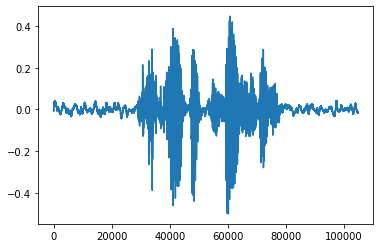

In [167]:
clean_folder = "/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/clean_trainset_56spk_wav/"
clean_file = random.choice(os.listdir(clean_folder))
clean_path = os.path.join(clean_folder, clean_file)

wave, sr = librosa.load(clean_path, mono= True, sr= None)
plt.plot(wave)
print(f"wave : {wave.shape}, sr: {sr}")
ipd.Audio(clean_path)

noise wave : (104830,), sr: 48000


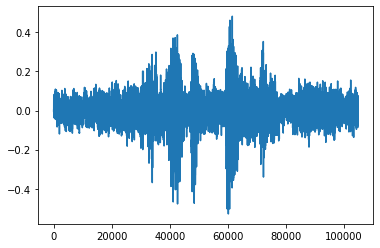

In [168]:
noise_folder = "/Volumes/IPEVO_X0244/speech_to_text/speech_to_text_dataset/noisy_trainset_56spk_wav/"
noise_path = os.path.join(noise_folder, clean_file)

noise_wave, noise_sr = librosa.load(noise_path, mono= True, sr= None)
print(f"noise wave : {noise_wave.shape}, sr: {sr}")
plt.plot(noise_wave)
ipd.Audio(noise_path)

In [169]:
np_samples = 50
epochs = 10
batch_size = 20
sample_rate = 8000
min_duration = 1.0
frame_length = 8046
hop_length_frame = 8046
hop_length_frame_noise = 5000
n_fft = 255
hop_length_fft = 63
dim_square_spec = int(n_fft / 2) + 1

In [170]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]

    sound_data_list = [sound_data[start : start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    
    print(f"sequence sample length : {sequence_sample_length}")
    print(f"frame length : {frame_length}, hop length frame : {hop_length_frame}")
    print(f"len of sound data list : {len(sound_data_list)}")
    sound_data_array = np.vstack(sound_data_list)

    return sound_data_array

def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    for file in list_audio_files:
        # open the audio file
        y, sr = librosa.load(os.path.join(audio_dir, file), sr = sample_rate)
        total_duration = librosa.get_duration(y = y, sr = sr)

        if (total_duration >= min_duration):
            list_sound_array.append(
                audio_to_audio_frame_stack(y, frame_length, hop_length_frame))
        else:
            print(
                f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)



In [171]:
voice = audio_files_to_numpy(clean_folder, 
                             [clean_file], 
                             sample_rate, 
                             frame_length, 
                             hop_length_frame, 
                             min_duration)

noise = audio_files_to_numpy(noise_folder, 
                             [clean_file], 
                             sample_rate, 
                             frame_length, 
                             hop_length_frame, 
                             min_duration)

print(f"voice shape: {voice.shape}")
print(f"noise shape: {noise.shape}")


sequence sample length : 17472
frame length : 8046, hop length frame : 8046
len of sound data list : 2
sequence sample length : 17472
frame length : 8046, hop length frame : 8046
len of sound data list : 2
voice shape: (2, 8046)
noise shape: (2, 8046)


In [172]:
print(f"wave shape : {wave.shape}")
print(146135 /  8046)
# ([start for start in range(0, 146135 - 8046 + 1, 8046)])


wave shape : (104830,)
18.162440964454387


In [173]:
def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase

def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    nb_audio = numpy_audio.shape[0]

    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(voice, 
                                                                 dim_square_spec, 
                                                                 n_fft,
                                                                 hop_length_fft)
m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(noise, 
                                                                 dim_square_spec,
                                                                 n_fft,
                                                                 hop_length_fft)
print(f"m amp db voice shape : {m_amp_db_voice.shape}, m phase voice shape: {m_pha_voice.shape}")
print(f"m amp db noise shape: {m_amp_db_noise.shape}, m phase noise shape: {m_pha_noise.shape}")

m amp db voice shape : (2, 128, 128), m phase voice shape: (2, 128, 128)
m amp db noise shape: (2, 128, 128), m phase noise shape: (2, 128, 128)


In [174]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 ) / 82
    return matrix_spec

def inv_scaled_in(matrix_spec):
    "inverse global scaling apply to noisy voices spectrograms"
    matrix_spec = matrix_spec * 50 - 46
    return matrix_spec

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

In [175]:
X_in = m_amp_db_noise
X_ou = m_amp_db_voice

X_in = scaled_in(X_in)
X_ou = scaled_ou(X_ou)

In [176]:
from scipy import stats
stats.describe(X_in.reshape(-1,1))

DescribeResult(nobs=32768, minmax=(array([-0.68]), array([0.92])), mean=array([0.14090988]), variance=array([0.06169216]), skewness=array([-0.53555862]), kurtosis=array([1.50667911]))

In [177]:
print(f"x in shape: {X_in.shape}")
print(f"x ou shape: {X_ou.shape}")
X_in = np.expand_dims(X_in, -1)
X_ou = np.expand_dims(X_ou, -1)
print(f"x in shape: {X_in.shape}")
print(f"x ou shape: {X_ou.shape}")

x in shape: (2, 128, 128)
x ou shape: (2, 128, 128)
x in shape: (2, 128, 128, 1)
x ou shape: (2, 128, 128, 1)


In [178]:
import keras
import keras.backend as K
from keras import layers, models, optimizers
import tensorflow as tf

In [179]:
def unet(input_size = (128,128,1), verbose = False):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = layers.Input(input_size)
    conv1 = layers.Conv2D(size_filter_in, 
                          3, 
                          activation = activation_layer, 
                          padding = 'same', 
                          kernel_initializer = kernel_init)(inputs)
    conv1 = layers.LeakyReLU()(conv1)
    conv1 = layers.Conv2D(size_filter_in, 
                          3, 
                          activation = activation_layer, 
                          padding = 'same',
                          kernel_initializer = kernel_init)(conv1)
    conv1 = layers.LeakyReLU()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(size_filter_in * 2, 
                          3, 
                          activation = activation_layer,
                          padding = 'same', 
                          kernel_initializer = kernel_init)(pool1)
    conv2 = layers.LeakyReLU()(conv2)
    conv2 = layers.Conv2D(size_filter_in * 2, 
                          3, 
                          activation = activation_layer, 
                          padding = 'same',
                          kernel_initializer = kernel_init)(conv2)
    conv2 = layers.LeakyReLU()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(size_filter_in * 4, 
                          3, 
                          activation = activation_layer,
                          padding = 'same',
                          kernel_initializer = kernel_init)(pool2)
    conv3 = layers.LeakyReLU()(conv3)
    conv3 = layers.Conv2D(size_filter_in * 4, 
                          3,
                          activation = activation_layer, 
                          padding = 'same', 
                          kernel_initializer = kernel_init)(conv3)
    conv3 = layers.LeakyReLU()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(size_filter_in * 8, 
                          3, 
                          activation = activation_layer,
                          padding = 'same', 
                          kernel_initializer = kernel_init)(pool3)
    conv4 = layers.LeakyReLU()(conv4)
    conv4 = layers.Conv2D(size_filter_in * 8,
                          3,
                          activation = activation_layer,
                          padding = 'same',
                          kernel_initializer = kernel_init)(conv4)
    conv4 = layers.LeakyReLU()(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(size_filter_in * 16,
                          3, activation = activation_layer,
                          padding = 'same',
                          kernel_initializer = kernel_init)(pool4)
    conv5 = layers.LeakyReLU()(conv5)
    conv5 = layers.Conv2D(size_filter_in * 16, 
                          3,
                          activation = activation_layer,
                          padding = 'same',
                          kernel_initializer = kernel_init)(conv5)
    conv5 = layers.LeakyReLU()(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv2D(size_filter_in * 8,
                        2,
                        activation = activation_layer,
                        padding = 'same',
                        kernel_initializer = kernel_init)(layers.UpSampling2D(size = (2,2))(drop5))
    up6 = layers.LeakyReLU()(up6)
#     merge6 = layers.concatenate([drop4, up6], axis = 3)
    merge6 = layers.Concatenate(axis = 3)([drop4, up6])
    conv6 = layers.Conv2D(size_filter_in * 8,
                          3,
                          activation = activation_layer, 
                          padding = 'same',
                          kernel_initializer = kernel_init)(merge6)
    conv6 = layers.LeakyReLU()(conv6)
    conv6 = layers.Conv2D(size_filter_in * 8, 
                          3, 
                          activation = activation_layer,
                          padding = 'same', 
                          kernel_initializer = kernel_init)(conv6)
    conv6 = layers.LeakyReLU()(conv6)
    up7 = layers.Conv2D(size_filter_in * 4,
                        2,
                        activation = activation_layer,
                        padding = 'same',
                        kernel_initializer = kernel_init)(layers.UpSampling2D(size = (2,2))(conv6))
    up7 = layers.LeakyReLU()(up7)
#     merge7 = layers.concatenate([conv3, up7], axis = 3)
    merge7 = layers.Concatenate(axis = 3)([conv3, up7])
    conv7 = layers.Conv2D(size_filter_in * 4, 
                          3, 
                          activation = activation_layer, 
                          padding = 'same', 
                          kernel_initializer = kernel_init)(merge7)
    conv7 = layers.LeakyReLU()(conv7)
    conv7 = layers.Conv2D(size_filter_in * 4, 
                          3,
                          activation = activation_layer,
                          padding = 'same',
                          kernel_initializer = kernel_init)(conv7)
    conv7 = layers.LeakyReLU()(conv7)
    up8 = layers.Conv2D(size_filter_in * 2,
                        2,
                        activation = activation_layer, 
                        padding = 'same',
                        kernel_initializer = kernel_init)(layers.UpSampling2D(size = (2,2))(conv7))
    up8 = layers.LeakyReLU()(up8)
#     merge8 = layers.concatenate([conv2,up8], axis = 3)
    merge8 = layers.Concatenate(axis = 3)([conv2, up8])
    conv8 = layers.Conv2D(size_filter_in * 2,
                          3,
                          activation = activation_layer,
                          padding = 'same',
                          kernel_initializer = kernel_init)(merge8)
    conv8 = layers.LeakyReLU()(conv8)
    conv8 = layers.Conv2D(size_filter_in * 2,
                          3,
                          activation = activation_layer, 
                          padding = 'same',
                          kernel_initializer = kernel_init)(conv8)
    conv8 = layers.LeakyReLU()(conv8)

    up9 = layers.Conv2D(size_filter_in,
                        2,
                        activation = activation_layer,
                        padding = 'same',
                        kernel_initializer = kernel_init)(layers.UpSampling2D(size = (2,2))(conv8))
    up9 = layers.LeakyReLU()(up9)
#     merge9 = layers.concatenate([conv1,up9], axis = 3)
    merge9 = layers.Concatenate(axis = 3)([conv1, up9])
    conv9 = layers.Conv2D(size_filter_in,
                          3, 
                          activation = activation_layer,
                          padding = 'same',
                          kernel_initializer = kernel_init)(merge9)
    conv9 = layers.LeakyReLU()(conv9)
    conv9 = layers.Conv2D(size_filter_in,
                          3,
                          activation = activation_layer, 
                          padding = 'same',
                          kernel_initializer = kernel_init)(conv9)
    conv9 = layers.LeakyReLU()(conv9)
    conv9 = layers.Conv2D(2, 
                          3,
                          activation = activation_layer,
                          padding = 'same',
                          kernel_initializer = kernel_init)(conv9)
    conv9 = layers.LeakyReLU()(conv9)
    conv10 = layers.Conv2D(1, 1, activation = 'tanh')(conv9)

    model = models.Model(inputs,conv10)

    if verbose :
        model.summary()
    return model

model = unet(verbose = True)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, 128, 128, 16) 160         input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_137 (LeakyReLU)     (None, 128, 128, 16) 0           conv2d_143[0][0]                 
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 128, 128, 16) 2320        leaky_re_lu_137[0][0]            
____________________________________________________________________________________________

In [180]:
optim = optimizers.Adam(learning_rate= 1e-5)
model.compile(optimizer=optim, loss = keras.losses.huber_loss, metrics = ['mae'])

In [181]:
model.load_weights("/Users/kehwaweng/Downloads/model_unet.h5")

In [182]:
X_pred = model.predict(X_in)
print(f"x pred shape: {X_pred.shape}")

x pred shape: (2, 128, 128, 1)


In [183]:
inv_sca_X_pred = inv_scaled_ou(X_pred)
print(f"inv sca x pred shape: {inv_sca_X_pred.shape}")
#Remove noise model from noisy speech
X_denoise = m_amp_db_noise - inv_sca_X_pred[:,:,:,0]
print(f" x denoise shape : {X_denoise.shape}")

inv sca x pred shape: (2, 128, 128, 1)
 x denoise shape : (2, 128, 128)


In [184]:
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

In [185]:
audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_noise, frame_length, hop_length_fft)
print(f"audio denoise reconstruct : {audio_denoise_recons.shape}")

audio denoise reconstruct : (2, 8046)


In [186]:
nb_samples = audio_denoise_recons.shape[0]
denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10

In [187]:
import soundfile as sf
sf.write("/Users/kehwaweng/Desktop/denoise_unet.wav", denoise_long[0, :], sample_rate)

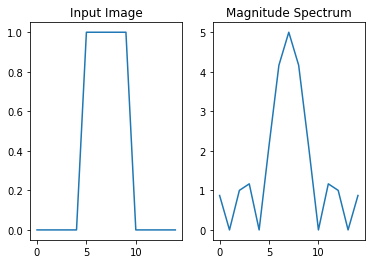

In [91]:
squareimpulse = np.array([0,0,0,0,0,1,1,1,1,1,0,0,0,0,0])

img = (squareimpulse)
f = np.fft.fft(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = (np.abs(fshift))

plt.subplot(121)
plt.plot(img)
plt.title('Input Image')

plt.subplot(122)
plt.plot(magnitude_spectrum)
plt.title('Magnitude Spectrum')

plt.show()